In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import subprocess
import re
import os
from IPython.core.display import display
pd.set_option('display.max_columns', None,'display.max_rows', None)
pd.set_option('display.max_colwidth', None)
#from ipynb_latex_setup import *
%matplotlib inline
T = 298.15
R = 8.314e-03
RT = R*T
display(RT)
N_avogadro = 6.022140857e+23

2.4788191

In [2]:
def molecular_partition_function(x):
    a = max(x)
    q_i = np.exp(x-a)
    sum_q_i = np.sum(q_i)
    log_q = (a + np.log(sum_q_i))
    return(log_q)

In [3]:
mindex_fixed = [np.array(['H+','H2O']),np.array([1,1])]
dgzero = 'DGZERO'
chg = 'Charge'
isomer = 'Pseudoisomer Index'
fx = 'Mole Fraction'
coeff = 'Stoich. Coeff'

In [4]:
mindex2 = [np.array(['PEP','PEP','PEP','PEP','ADP','ADP','ADP','ADP','ADP','ADP','pyruvate','pyruvate',\
                    'ATP','ATP','ATP','ATP','ATP','ATP']),np.array([1,2,3,4,1,2,3,4,5,6,1,2,1,2,3,4,5,6])]
reaction2 = pd.DataFrame(index=mindex2, columns=[chg, dgzero, fx])
reaction2.loc[('PEP'), chg] = np.array([0,-1,-2,-3])
reaction2.loc[('PEP'),coeff] = np.array([-1.0,-1.0,-1.0,-1.0])
reaction2.loc[('ADP'), chg] = np.array([0,-1,-2,-3,-4,-5])
reaction2.loc[('ADP'),coeff] = np.array([-1.0,-1.0,-1.0,-1.0,-1.0,-1.0])
reaction2.loc[('ATP'), chg] = np.array([0,-1,-2,-3,-4,-5])
reaction2.loc[('ATP'),coeff] = np.array([1.0,1.0,1.0,1.0,1.0,1.0])
reaction2.loc[('pyruvate'), chg] = np.array([0,-1])
reaction2.loc[('pyruvate'),coeff] = np.array([1.0,1.0])
results = pd.DataFrame()

# Phosphoenolpyruvate + ADP <=> Pyruvate + ATP

All free energies of formation in aqueous solution were obtained from http://equilibrator.weizmann.ac.il/, version 2.2 with source code repository commit hash f8bc4ca931f41ae08c5cf15b8945c1b1a85158d0, using the component contribution method ( Noor E, Haraldsdóttir HS, Milo R, Fleming RMT (2013) Consistent Estimation of Gibbs Energy Using Component Contributions. PLoS Comput Biol 9(7): e1003098. https://doi.org/10.1371/journal.pcbi.1003098) 

In [5]:
pH_vec = np.arange(0,9,0.1)
c_vec = np.zeros(np.shape(pH_vec))
ddg_vec = np.zeros(np.shape(pH_vec))
j = 0
for pH in pH_vec:
    log_Hconc = -pH*np.log(10)

    fixed_metabolite = pd.DataFrame(index=mindex_fixed, columns=[chg, dgzero, fx])
    fixed_metabolite.loc[('H+',1),dgzero] = np.float_(RT*log_Hconc)
    fixed_metabolite.loc[('H+',1), chg] = np.float_(1.0)
    fixed_metabolite.loc[('H+',1),fx] = np.float_(1.0)

    # Component contribution via eQuilibrator:
    reaction2.loc[('PEP',1),dgzero] = np.float_(-1324.8) 
    reaction2.loc[('PEP',2),dgzero] = np.float_(-1320.5) + fixed_metabolite.loc[('H+',1),dgzero] 
    reaction2.loc[('PEP',3),dgzero] = np.float_(-1300.2) + 2*fixed_metabolite.loc[('H+',1),dgzero] 
    reaction2.loc[('PEP',4),dgzero] = np.float_(-1265.9) + 3*fixed_metabolite.loc[('H+',1),dgzero] 

    # Component contribution via eQuilibrator:
    reaction2.loc[('ADP',1),dgzero] = np.float_(-1992.6) 
    reaction2.loc[('ADP',2),dgzero] = np.float_(-1974.3) + fixed_metabolite.loc[('H+',1),dgzero] 
    reaction2.loc[('ADP',3),dgzero] = np.float_(-1945.9) + 2*fixed_metabolite.loc[('H+',1),dgzero] 
    reaction2.loc[('ADP',4),dgzero] = np.float_(-1903.5) + 3*fixed_metabolite.loc[('H+',1),dgzero] 
    reaction2.loc[('ADP',5),dgzero] = np.float_(-1832.5) + 4*fixed_metabolite.loc[('H+',1),dgzero] 
    reaction2.loc[('ADP',6),dgzero] = np.float_(-1752.7) + 5*fixed_metabolite.loc[('H+',1),dgzero] 

    # Component contribution via eQuilibrator:
    reaction2.loc[('ATP',1),dgzero] = np.float_(-2875.9) 
    reaction2.loc[('ATP',2),dgzero] = np.float_(-2861.5) + fixed_metabolite.loc[('H+',1),dgzero] 
    reaction2.loc[('ATP',3),dgzero] = np.float_(-2842.7) + 2*fixed_metabolite.loc[('H+',1),dgzero] 
    reaction2.loc[('ATP',4),dgzero] = np.float_(-2814.2) + 3*fixed_metabolite.loc[('H+',1),dgzero] 
    reaction2.loc[('ATP',5),dgzero] = np.float_(-2771.8) + 4*fixed_metabolite.loc[('H+',1),dgzero] 
    reaction2.loc[('ATP',6),dgzero] = np.float_(-2700.0) + 5*fixed_metabolite.loc[('H+',1),dgzero] 

    # Component contribution via eQuilibrator:
    reaction2.loc[('pyruvate',1),dgzero] = np.float_(-483.6) 
    reaction2.loc[('pyruvate',2),dgzero] = np.float_(-466.9) + fixed_metabolite.loc[('H+',1),dgzero] 

    # Calculate molecular partition function for PEP
    x = np.array([-(reaction2.loc[('PEP',i),dgzero]/RT) for i in range(1,5)])
    log_q_pep = molecular_partition_function(x)

    # Calculate molecular partition function for ADP
    x = np.array([-(reaction2.loc[('ADP',i),dgzero]/RT) for i in range(1,7) ])
    log_q_adp = molecular_partition_function(x)

    # Calculate molecular partition function for ATP
    x = np.array([-(reaction2.loc[('ATP',i),dgzero]/RT) for i in range(1,7) ])
    log_q_atp = molecular_partition_function(x)

    # Calculate molecular partition function for pyruvate
    x = np.array([-(reaction2.loc[('pyruvate',i),dgzero]/RT) for i in range(1,3) ])
    log_q_pyr = molecular_partition_function(x)

    for i in range(1,5):
        reaction2.loc[('PEP',i),fx] = np.exp(-reaction2.loc[('PEP',i),dgzero]/RT - log_q_pep)

    for i in range(1,7):
        reaction2.loc[('ADP',i),fx] = np.exp(-reaction2.loc[('ADP',i),dgzero]/RT - log_q_adp)

    for i in range(1,7):
        reaction2.loc[('ATP',i),fx] = np.exp(-reaction2.loc[('ATP',i),dgzero]/RT - log_q_atp)

    for i in range(1,3):
        reaction2.loc[('pyruvate',i),fx] = np.exp(-reaction2.loc[('pyruvate',i),dgzero]/RT - log_q_pyr)

    #BBR:
    dg0_bbr = np.sum(reaction2[dgzero].multiply(reaction2[fx].multiply(reaction2[coeff]))) 
    #display('BBR:',dg0_bbr)
    #Alberty
    dg0_a = (-1)*RT*log_q_pep*reaction2.loc[('PEP',1),coeff] + \
        (-1)*RT*log_q_adp*reaction2.loc[('ADP',1),coeff] + \
        (-1)*RT*log_q_pyr*reaction2.loc[('pyruvate',1),coeff] + \
        (-1)*RT*log_q_atp*reaction2.loc[('ATP',1),coeff]
    #display('Alberty:',dg0_a)
    if (pH%1 == 0):
        results.loc['BBR',pH] = dg0_bbr
        results.loc['Alberty',pH] = dg0_a
    ddg = (dg0_bbr-dg0_a)
    c = np.exp(np.abs(ddg)/RT)
    #print(c,ddg)
    c_vec[j] = c
    ddg_vec[j] = ddg
    j += 1

display(results)

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0
BBR,-42.694418,-40.919082,-34.626944,-32.48775,-35.302351,-35.693618,-35.027716,-29.866917,-23.753206
Alberty,-41.705903,-39.662456,-35.591050,-33.63184,-34.593709,-34.763228,-33.314772,-29.105780,-23.613282


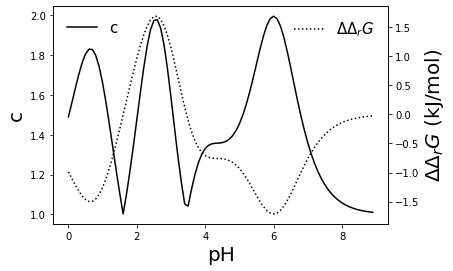

In [6]:
fig, ax1 = plt.subplots() 
ax2 = ax1.twinx()
ax1.plot(pH_vec,c_vec,'k-',label='c')
ax2.plot(pH_vec,ddg_vec,'k:', label='$\Delta \Delta_r G$')

ax1.set_xlabel('pH', fontsize=20)
ax1.set_ylabel('c', fontsize=20)
ax2.set_ylabel('$\Delta \Delta_r G$ (kJ/mol)',fontsize=20)
ax1.legend(frameon=False,loc=2,fontsize=15)
ax2.legend(frameon=False,loc=0,fontsize=15)

plt.savefig('c_vs_pH.png',bbox_inches='tight')